In [1]:
import time 
import os
import uuid
import cv2

In [90]:
IMG_PATH = os.path.join('facedet','data','images')
num_imgs = 30

In [91]:
cap = cv2.VideoCapture(0)
for imgnum in range(num_imgs):
    print('Collecting image {}'.format(imgnum))
    ret,frame = cap.read()
    imgname = os.path.join(IMG_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [ ]:
!pip install labelme

In [ ]:
!labelme

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
    tf.config.experimental.set_memory_growth(i,True)

In [ ]:
tf.test.is_gpu_available()

In [ ]:
imgs = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [ ]:
imgs.as_numpy_iterator().next()

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
imgs = imgs.map(load_image)

NameError: name 'imgs' is not defined

In [ ]:
imgs.as_numpy_iterator().next()

In [ ]:
type(imgs)

In [ ]:
img_generator = imgs.batch(4).as_numpy_iterator()

In [ ]:
plot_img = img_generator.next()

In [ ]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for i,j in enumerate(plot_img):
    ax[i].imshow(j)
plt.show()    

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

In [3]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [6]:
image = cv2.imread(os.path.join('data','train','images','1a4c43e5-02a5-11ee-8d1f-54e1ad686ca9.jpg'))

In [7]:
with open(os.path.join('data', 'train', 'labels', '1a4c43e5-02a5-11ee-8d1f-54e1ad686ca9.json'), 'r') as f:
    label = json.load(f)

NameError: name 'json' is not defined

In [8]:
label['shapes'][0]['points']

NameError: name 'label' is not defined

In [8]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [9]:
coords

[86.24365482233503, 75.0253807106599, 416.1928934010152, 382.6395939086295]

In [10]:
coords = list(np.divide(coords,[640,480,640,480]))

In [11]:
coords

[0.1347557106598985,
 0.15630287648054147,
 0.6503013959390863,
 0.797165820642978]

In [12]:
augmented = augmentor(image=image,bboxes=[coords],class_labels=['face'])

NameError: name 'augmentor' is not defined

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])           

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [13]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [14]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [16]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.01727, 0.1184 , 0.482  , 0.8325 ], dtype=float16))

In [18]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [19]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [20]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [21]:
train_images.as_numpy_iterator().next()

array([[[0.5387255 , 0.54656863, 0.50232846],
        [0.5441176 , 0.5599877 , 0.49767157],
        [0.5529412 , 0.57009804, 0.49607843],
        ...,
        [0.29577205, 0.2996936 , 0.31605393],
        [0.28694853, 0.3060662 , 0.3185049 ],
        [0.2872549 , 0.3019608 , 0.325     ]],

       [[0.54295343, 0.55196077, 0.4910539 ],
        [0.5421569 , 0.55784315, 0.45882353],
        [0.5530025 , 0.57555145, 0.47322303],
        ...,
        [0.31378677, 0.31084558, 0.37555146],
        [0.29607844, 0.31029412, 0.3602941 ],
        [0.29172793, 0.30833334, 0.34448528]],

       [[0.54479164, 0.5526348 , 0.4620711 ],
        [0.54901963, 0.56078434, 0.4852941 ],
        [0.5598039 , 0.5715686 , 0.50392157],
        ...,
        [0.33284312, 0.325     , 0.41911766],
        [0.32542893, 0.32892156, 0.41256127],
        [0.3122549 , 0.33137256, 0.39754903]],

       ...,

       [[0.12579657, 0.12971814, 0.1101103 ],
        [0.15827206, 0.16268383, 0.14307599],
        [0.17297794, 0

In [22]:
len(train_images),len(train_labels)

(3540, 3540)

In [23]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [24]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [25]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [26]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.0916 , 0.4639 , 0.8047 ],
        [0.0713 , 0.08044, 0.5464 , 0.7935 ],
        [0.5396 , 0.1776 , 1.     , 0.922  ],
        [0.6016 , 0.1145 , 1.     , 0.796  ],
        [0.     , 0.12317, 0.5195 , 0.7456 ],
        [0.404  , 0.1252 , 0.8125 , 0.8438 ],
        [0.248  , 0.269  , 0.767  , 0.9346 ]], dtype=float16))

In [27]:
data_samples = train.as_numpy_iterator()

In [28]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


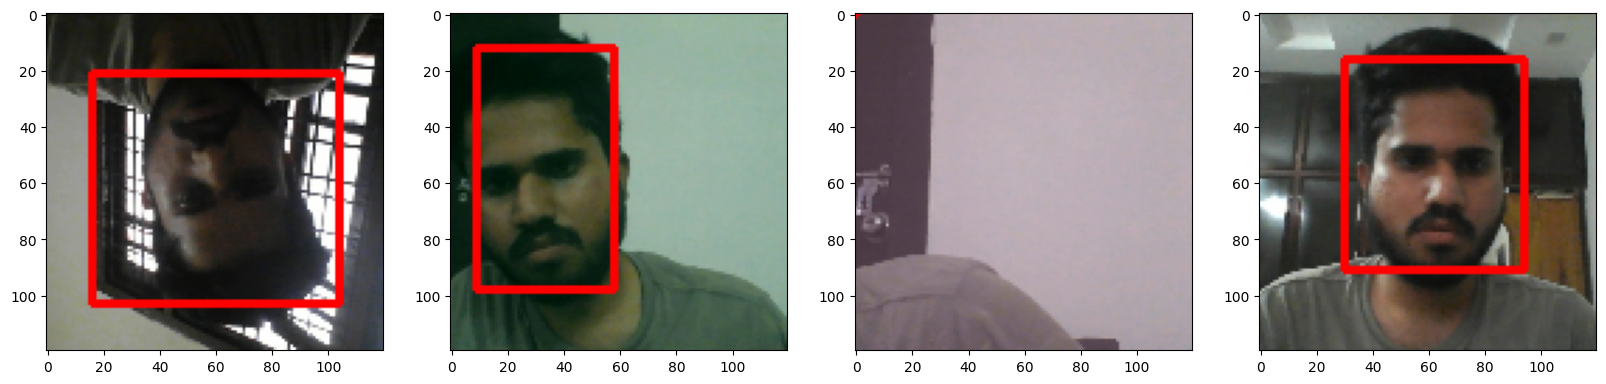

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [31]:
vgg = VGG16(include_top=False)

In [32]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [33]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

    u1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048,activation='relu')(u1)
    class2 = Dense(1,activation='sigmoid')(class1)

    u2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048,activation='relu')(u2)
    regress2 = Dense(4,activation='sigmoid')(regress1)

    FaceDetect = Model(inputs=input_layer,outputs=[class2,regress2])
    return FaceDetect
 

In [34]:
FaceDetect = build_model()

In [35]:
FaceDetect.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [36]:
x,y = train.as_numpy_iterator().next()

In [37]:
x.shape

(8, 120, 120, 3)

In [38]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2241 , 0.2166 , 0.761  , 0.926  ],
        [0.     , 0.1517 , 0.276  , 0.87   ],
        [0.5615 , 0.1627 , 1.     , 0.791  ],
        [0.686  , 0.0696 , 1.     , 0.789  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.09357, 0.03078, 0.5864 , 0.7495 ]], dtype=float16))

In [39]:
classes, coords = FaceDetect.predict(x)

1/1 [==============================] - 1s 888ms/step


In [40]:
classes,coords

(array([[0.51437306],
        [0.4993404 ],
        [0.5163467 ],
        [0.44095084],
        [0.5693654 ],
        [0.4810404 ],
        [0.52749634],
        [0.5702698 ]], dtype=float32),
 array([[0.3390256 , 0.2969277 , 0.48203334, 0.49472642],
        [0.34016576, 0.32735825, 0.48727497, 0.40350586],
        [0.36535746, 0.30300546, 0.50079286, 0.39179987],
        [0.31895468, 0.27299464, 0.5454432 , 0.53792214],
        [0.38512325, 0.28936374, 0.522801  , 0.4282514 ],
        [0.38948315, 0.30002624, 0.535978  , 0.39631823],
        [0.41965958, 0.27328444, 0.5347571 , 0.42932096],
        [0.363645  , 0.2944481 , 0.5370754 , 0.49353048]], dtype=float32))

In [41]:
batch_per_seg = len(train)
lr_decay = (1./0.75 -1)/batch_per_seg

In [42]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [43]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [44]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [46]:
localization_loss(y[1], coords).numpy()

3.4142869

In [47]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6747673>

In [48]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.4142869>

In [49]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [50]:
model = FaceTracker(FaceDetect)

In [51]:
model.compile(opt,classloss,regressloss)

In [52]:
logdir = 'log'

In [53]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [54]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
443/443 [==============================] - 1192s 3s/step - total_loss: 0.3189 - class_loss: 0.0642 - regress_loss: 0.2868 - val_total_loss: 0.0948 - val_class_loss: 0.0183 - val_regress_loss: 0.0856
Epoch 2/10
443/443 [==============================] - 1283s 3s/step - total_loss: 0.0630 - class_loss: 0.0101 - regress_loss: 0.0580 - val_total_loss: 0.0339 - val_class_loss: 8.8801e-04 - val_regress_loss: 0.0334
Epoch 3/10
443/443 [==============================] - 1206s 3s/step - total_loss: 0.0419 - class_loss: 0.0070 - regress_loss: 0.0384 - val_total_loss: 0.0175 - val_class_loss: 0.0012 - val_regress_loss: 0.0169
Epoch 4/10
443/443 [==============================] - 1115s 3s/step - total_loss: 0.0294 - class_loss: 0.0050 - regress_loss: 0.0269 - val_total_loss: 0.0328 - val_class_loss: 1.4694e-04 - val_regress_loss: 0.0327
Epoch 5/10
443/443 [==============================] - 1146s 3s/step - total_loss: 0.0276 - class_loss: 0.0051 - regress_loss: 0.0250 - val_total_loss: 0

In [55]:
hist.history

{'total_loss': [0.05346715450286865,
  0.1146552711725235,
  0.02006162889301777,
  0.006934949196875095,
  0.016679950058460236,
  0.0064841522835195065,
  0.003014126094058156,
  0.00333201140165329,
  0.0023005653638392687,
  0.003959923516958952],
 'class_loss': [0.0006059841252863407,
  0.039953697472810745,
  9.288617002312094e-05,
  4.063691449118778e-05,
  2.2158441424835473e-05,
  0.00010023333015851676,
  9.979149035643786e-05,
  1.3217461855674628e-05,
  1.284497557207942e-05,
  5.229069211054593e-05],
 'regress_loss': [0.05316416174173355,
  0.09467842429876328,
  0.020015185698866844,
  0.0069146305322647095,
  0.01666887104511261,
  0.006434035487473011,
  0.002964230254292488,
  0.0033254027366638184,
  0.0022941429633647203,
  0.003933778032660484],
 'val_total_loss': [0.09481580555438995,
  0.03387884795665741,
  0.01751246303319931,
  0.03280484676361084,
  0.008121980354189873,
  0.023393353447318077,
  0.035177264362573624,
  0.014583180658519268,
  0.01044296193867

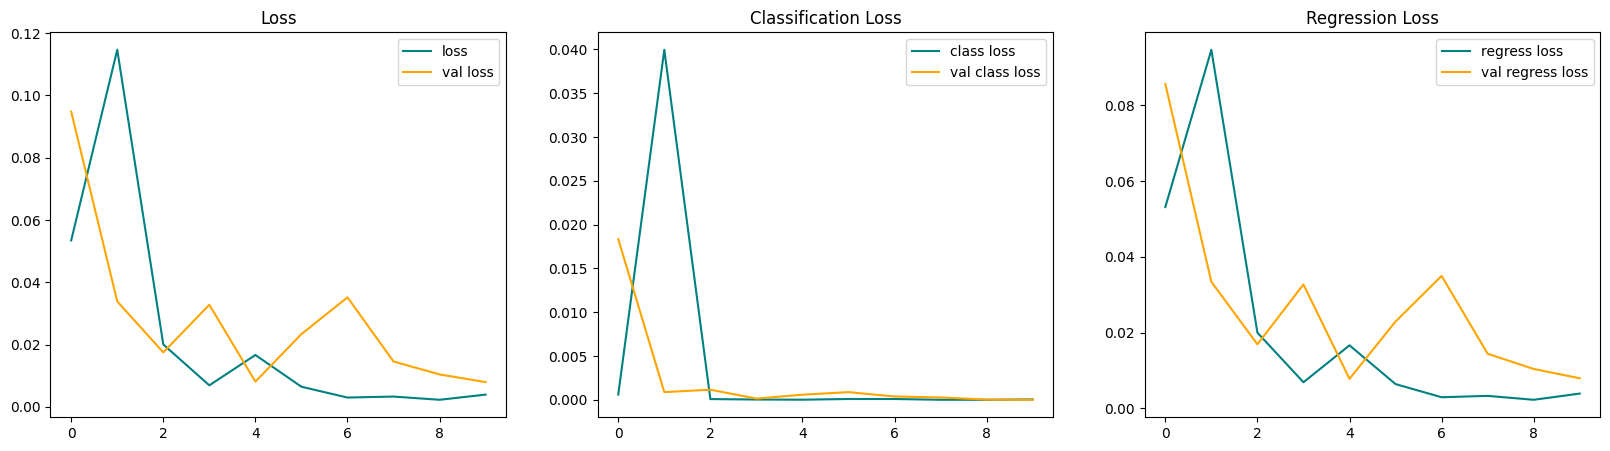

In [56]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [4]:
test_data = test.as_numpy_iterator()

NameError: name 'test' is not defined

In [63]:
test_sample = test_data.next()

In [64]:
yhat = FaceDetect.predict(test_sample[0])

1/1 [==============================] - 1s 602ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


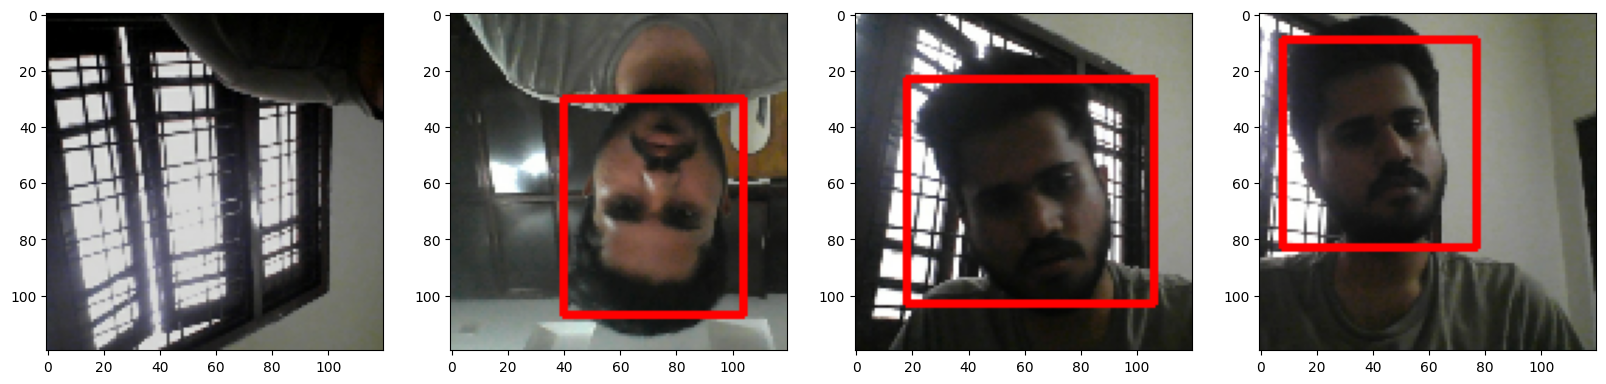

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [66]:
from tensorflow.keras.models import save_model

In [6]:
from tensorflow.keras.models import load_model

In [68]:
FaceDetect.save('facedetect.h1')

INFO:tensorflow:Assets written to: facedetect.h1\assets


INFO:tensorflow:Assets written to: facedetect.h1\assets


In [69]:
FaceDetect = load_model('facedetect.h1')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:700, 70:700,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = FaceDetect.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
    
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 131ms/step


In [7]:
FaceDetect = load_model('facedetect.h1')